In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as keras

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
# Download folder and unzip it
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')


182083584/182082353 [==============================] - 1s 0us/step
Commands: ['up' 'yes' 'down' 'no' 'left' 'go' 'right' 'stop']
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/bfbd0e6b_nohash_0.wav', shape=(), dtype=string)


In [ ]:
# Print commands
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

# Shuffle audio samples and print some info
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
print(type(filenames))
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Commands: ['up' 'yes' 'down' 'no' 'left' 'go' 'right' 'stop']
<class 'tensorflow.python.framework.ops.EagerTensor'>
Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/a24cf51c_nohash_1.wav', shape=(), dtype=string)


In [ ]:
# Split dataset
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
'''
The audio file will initially be read as a binary file, which you'll want to convert into a numerical tensor.
To load an audio file, you will use tf.audio.decode_wav, which returns the WAV-encoded audio as a Tensor and the sample rate.
A WAV file contains time series data with a set number of samples per second. Each sample represents the amplitude of the audio signal at that specific time.
In a 16-bit system, like the files in mini_speech_commands, the values range from -32768 to 32767. The sample rate for this dataset is 16kHz. 
Note that tf.audio.decode_wav will normalize the values to the range [-1.0, 1.0].
'''
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [ ]:
'''
You will now apply process_path to build your training set to extract the audio-label pairs and check the results. 
You'll build the validation and test sets using a similar procedure later on.
'''
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
print(type(files_ds))
print(files_ds)
print(type(waveform_ds))
print(waveform_ds.take(0))
audio, label = waveform_ds.take(2)
print(len(audio[0]))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<TensorSliceDataset shapes: (), types: tf.string>
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
<TakeDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>
16000


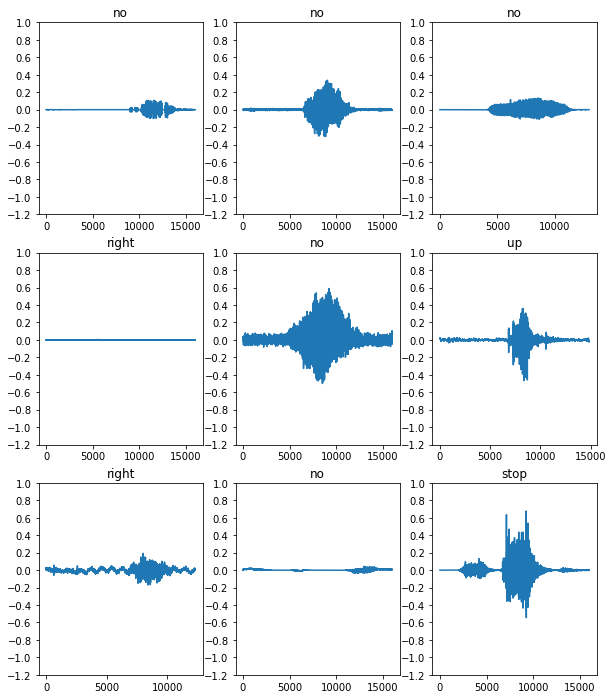

In [ ]:
# Do some ploting to view the dataset
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
# We need the waveforms to have a similar length.
# This can be done by simply zero padding the audio clips that are shorter than one second.

def zero_pad_the_waveforms(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)

  return equal_length

In [ ]:
# Explore the data
for waveform, label in waveform_ds.take(2000):
  label = label.numpy().decode('utf-8')
  audio_one = zero_pad_the_waveforms(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Audio one shape:', audio_one.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))
print(audio_one)

Label: left
Waveform shape: (16000,)
Audio one shape: (16000,)
Audio playback


tf.Tensor(
[-0.0012207  -0.00228882 -0.00296021 ... -0.00314331 -0.00305176
 -0.00213623], shape=(16000,), dtype=float32)


In [ ]:
def get_zero_padded_waveforms_and_label_id(audio, label):
  audio_one = zero_pad_the_waveforms(audio)
  label_id = tf.argmax(label == commands)
  return audio_one, label_id

audio_zero_padded_ds = waveform_ds.map(get_zero_padded_waveforms_and_label_id, num_parallel_calls=AUTOTUNE)

In [ ]:
# Helper function for dataset
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_zero_padded_waveforms_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

train_ds = audio_zero_padded_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)